# Практическая задача (36 баллов)

В этой задаче мы поработаем с разреженными системами, в том числе научимся быстро пересчитывать решение при изменениях ранга 1 в матрице левой части.

In [73]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Расчёт напряжений в системе резисторов

При конструировании сверхбольших интегральных схем (СБИС, very large scale integration, VLSI) одной из базовых задачей является расчёт напряжений в электрических схемах довольно внушительных размеров. Мы рассмотрим модельный пример: сетку $m \times n$ с резисторами сопротивления $R$.

![Сетка из резисторов](resistors.svg)

Потенциалы в узлах сетки обозначим $\varphi_{ij}$, это и будут наши неизвестные. Давайте также считать, что к противоположным углам сетки ($(1,1)$ и $(m,n)$) приложена разность потенциалов $U$. Соответственно, в левый верхний угол втекает (неизвестный) ток $I$, и такой же ток вытекает из правого нижнего угла.

Для решения системы нам будет достаточно закона Ома и первого закона Кирхгофа. Именно, для каждого резистора легко выразить текущий через него ток. Например, для горизонтального резистора между узлами $(i,j)$ и $(i,j+1)$ ток равен $I_{i,j} = (\varphi_{ij} - \varphi_{i,j+1})/R$. Далее применяем первый закон Кирхгофа для каждого узла $(i,j)$, то есть приравниваем сумму втекающих токов к сумме вытекающих. Для внутреннего узла получим такое равенство:
$$
\frac{\varphi_{i,j-1} - \varphi_{i,j}}{R} + \frac{\varphi_{i-1,j} - \varphi_{i,j}}{R} - \frac{\varphi_{i,j} - \varphi_{i,j+1}}{R} - \frac{\varphi_{i,j} - \varphi_{i+1,j}}{R} = 0.\tag{1}
$$
На границе, например, верхней (то есть $i = 1$), будет отсутствовать член $\varphi_{i-1,j}-\varphi_{i, j}$, а в углу, например, $(1,n)$, будет дополнительно отсутствовать член $\varphi_{i,j}-\varphi_{i, j+1}$. В углах $(1,1)$ и $(m, n)$, однако, ситуация особая: в первом есть дополнительный втекающий неизвестный ток $I$, а во втором этот же ток вытекает.
В результате получим систему на $\varphi_{i,j}$ и $I$:
$$
\left[ \begin{array}{ccccc|c}
   &&   && &  R \\
   &&   && &  0 \\
   && A && &  \vdots  \\
   &&   && &  0 \\
   &&   && & -R \\
   \hline
1 & 0 & \dots &  0 & -1 & 0
\end{array}
\right]
\begin{bmatrix}
\varphi_{11} \\
\vdots       \\
\vdots       \\
\vdots       \\
\varphi_{mn}  \\
I
\end{bmatrix}
=
\begin{bmatrix}
0 \\
\vdots       \\
\vdots       \\
\vdots       \\
0  \\
U
\end{bmatrix}
$$
Последнее уравнение есть $\varphi_{11}-\varphi_{mn} = U$.

Разберёмся с видом матрицы $A$. Она имеет размеры $mn \times mn$ и индексируется двумя парами индексов $ij$ и $i'j'$. Перепишем уравнение (2) в виде 
$$
(\varphi_{i,j-1} - 2\varphi_{i,j} + \varphi_{i,j+1}) + (\varphi_{i-1,j} - 2\varphi_{i,j} + \varphi_{i+1,j}) = 0.\tag{2}
$$
Если переписать столбец $\varphi$ с элементами $\varphi_{ij}$ в матрицу $\Phi\in\mathbb{R}^{m \times n}$ естественным образом (то есть так, чтобы $\mathrm{vec}(\Phi) = \varphi$), то ясно, что первое слагаемое в (2) действует на столбцы матрицы $\Phi$, а второе &mdash; на строки. То есть $A \varphi  = \mathrm{vec}(\Phi A_n) + \mathrm{vec}(A_m \Phi)$, где $A_n \in \mathbb{R}^{n \times n}$ и $A_m \in \mathbb{R}^{m \times m}$ имеют вид
$$
\begin{bmatrix}
-1 & 1 & &  \\
1 & -2 & 1 & \\
  &   & \ddots &  \\
  &     &    1 & -1
 \end{bmatrix}.
$$
По уже известной нам формуле для $\mathrm{vec}(\cdot)$ получается, что $A = A_n \otimes I_m + I_n \otimes A_m$. Операция в правой части ещё называется *Кронекеровой суммой* матриц $A_n$ и $A_m$ и обозначается $A_n \oplus A_m$ (можете проверить, что такая "сумма" не имеет такого интуитивного свойство суммы, как коммутативность, т.е. в общем случае $A_m \oplus A_n \neq A_n \oplus A_m$).

**Обратите внимание**, что система получилась линейно зависимой: если сложить все строки, кроме последней, получится нулевая строка (физически это отвечает тому, что все потенциалы можно сдвинуть на одинаковую константу).
Поэтому мы удалим предпоследнюю строку (не потеряв никакой информации, ведь она равнялась минус сумме остальных), а вместо неё добавим условие $\varphi_{mn} = 0$, таким образом фиксируя один из потенциалов, чтобы уничтожить неопределённость. Обозначим получившуюся $(mn+1)\times(mn+1)$ матрицу $B$.

## 1. Разреженное LU-разложение (16 баллов)

a. (**9 баллов**) Сформируйте разреженную матрицу решаемой системы в CSC формате. Для получения матриц $A_m, A_n$ используйте `scipy.sparse.spdiags`, а для сбора $A$ по $A_m, A_n$ используйте `scipy.sparse.kron` матрицы $A$. Обратите внимание, что в этом задании нельзя собирать $A$ или $A_m, A_n$ с использование операций с плотными матрицами.

In [74]:
from scipy import sparse

def make_A(m, n):
    "Returns sparse mn x mn matrix A"
    diags = np.array([-1, 0, 1])
    data_n = np.array([[1] * n, [-1] + [-2] * (n - 2) + [-1], [1] * n])
    data_m = np.array([[1] * m, [-1] + [-2] * (m - 2) + [-1], [1] * m])
    An = sparse.spdiags(data_n, diags, n, n, format='lil')
    Am = sparse.spdiags(data_m, diags, m, m, format='lil')
    A = sparse.kron(An, sparse.eye(m), format='lil') + sparse.kron(sparse.eye(n), Am, format='lil')
    return A
    
def make_mat(m, n, R):
    "Returns sparse (mn + 1) x (mn + 1) matrix of the system in CSC format"
    A = make_A(m, n)
    A[m * n - 1, :] = 0
    A[m * n - 1, m * n - 1] = 1
    res = sparse.vstack([sparse.vstack([A, [1] + [0] * (m * n - 2) + [-1]]).T, [R] + [0] * (m * n - 2) + [0] + [0]]).T
    return res.tocsc()

b. (**7 баллов**) Заполните класс `Solver`, который при инициализации выполнит разреженное LU-разложение с помощью библиотеки `scipy.sparse.linalg` и функции `scipy.sparse.linalg.splu`, а затем будет уметь решать систему для заданной правой части.

In [75]:
import scipy.sparse.linalg

class Solver:
    def __init__(self, m, n, R):
        A = make_mat(m, n, R)
        self.m = m
        self.n = n
        self.R = R
        self.solver = scipy.sparse.linalg.splu(A)
    
    def solve(self, right):
        "Solves the system for given right part"
        res = self.solver.solve(right)
        return res

    def solve_voltage(self, U):
        "Solves the updated system for given voltage"
        right = np.array([0] * (m * n) + [U])
        res = self.solve(right)
        return res

Решим систему и визуализируем полученное решение, чтобы понять, как текут токи.

In [76]:
def visualize(m, n, R, solution, resistance_coeffs={}):
    plt.axis('off')
    max_current = 0
    lines = []
    for i in range(m):
        for j in range(n - 1):
            resistance = R * resistance_coeffs.get((i, j), 1)
            current = (solution[j * m + i] - solution[(j + 1) * m + i]) / resistance
            dx = 0.2 if current > 0 else -0.2
            plt.arrow(j+0.5, -i, dx, 0, shape='full', lw=2, length_includes_head=True, head_width=.10, color='blue')
            max_current = max(max_current, current)
            lines += plt.plot([j, j + 1], [-i, -i], color='blue', lw=abs(current))
    for i in range(m - 1):
        for j in range(n):
            current = (solution[j * m + i] - solution[j * m + i + 1]) / R
            dy = -0.1 if current > 0 else 0.1
            plt.arrow(j, -i - 0.5, 0, dy, shape='full', lw=2, length_includes_head=True, head_width=.08, color='blue')
            max_current = max(max_current, current)
            lines += plt.plot([j, j], [-i, -i - 1], color='blue', lw=abs(current))
    for l in lines:
        l.set_linewidth(l.get_linewidth() * 4. / max_current)

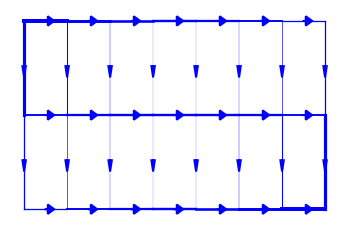

In [77]:
m, n, R = 3, 8, 1.
solver = Solver(m, n, R)
visualize(m, n, R, solver.solve_voltage(220.))

Проверьте, что ваш солвер работает для больших систем.

In [78]:
m, n, R = 500, 500, 1.
solver = Solver(m, n, R)
_ = solver.solve_voltage(220.)

## 2. Обновления ранга 1 (20 баллов)

Представим теперь, что в процессе работы резисторы в нашей системе могут менять своё сопротивление, например, при перегреве проводник может потерять проводимость ($R_{i,j} = \infty$) или, напротив, может произойти короткое замыкание ($R_{i,j} = 0$). При таких локальных изменениях нет нужды строить и решать заново всю нашу линейную систему.

a. (**8 баллов**) Будем считать для простоты, что
  1. сопротивление меняется только в горизонтальных резисторах, не инцидентных узлам $(1,1)$ и $(m, n)$;
  2. в каждом проводе сопротивление может измениться только один раз.

Пусть сопротивление между узлами $(i,j)$ и $(i,j+1)$ изменилось с $R$ на $R'$. Пользуясь формулой (1), выпишите новую матрицу $B'$ в виде $B' = B + uv^\top$.


(можно написать решение в строчке ниже или на листке в теоретической части)

**Решение:**   
При изменении $R$ на $R'$ поменяются формулы (1) для узлов $(i, j)$ и $(i, j + 1)$. Сначала рассмотрим узел $(i, j)$.
$$
\frac{\varphi_{i,j-1} - \varphi_{i,j}}{R} + \frac{\varphi_{i-1,j} - \varphi_{i,j}}{R} - \frac{\varphi_{i,j} - \varphi_{i,j+1}}{R} - \frac{\varphi_{i,j} - \varphi_{i+1,j}}{R} = 0.\tag{1}
$$  
Тогда ток между узлами $(i, j)$ и $(i, j + 1)$ будет равен $I_{ij} = \frac{\varphi_{i,j} - \varphi_{i,j+1}}{R'}$. Тогда подставляя такой ток в формулу (1) получаем:  
$$
\frac{\varphi_{i,j-1} - \varphi_{i,j}}{R} + \frac{\varphi_{i-1,j} - \varphi_{i,j}}{R} - \frac{\varphi_{i,j} - \varphi_{i,j+1}}{R'} - \frac{\varphi_{i,j} - \varphi_{i+1,j}}{R} = 0  
$$ 
$$
(\varphi_{i,j-1} - \varphi_{i,j}) + (\varphi_{i-1,j} - \varphi_{i,j}) - (\varphi_{i,j} - \varphi_{i,j+1}) \cdot \frac{R}{R'} - (\varphi_{i,j} - \varphi_{i+1,j}) = 0
$$  
Теперь из получившегося выше уравнения вычтем уравнение (2) и получим:  
$$
-(\varphi_{i,j} - \varphi_{i,j+1}) \cdot \frac{R}{R'} + (\varphi_{i,j} - \varphi_{i,j+1}) = 0
$$    
$$
-(\varphi_{i,j} - \varphi_{i,j+1}) \cdot \frac{R - R'}{R'} = 0
$$   
Тогда для узла $(i, j)$ уравнение изменится так: к (2) нужно прибавить уравнение выше. Тогда в матрице A нужно из элемента, который отвечает за $\varphi_{i,j}$ вычесть $\frac{R-R'}{R'}$ и к элементу, который отвечает за $\varphi_{i,j+1}$ прибавить $\frac{R-R'}{R'}$.   
Теперь рассмотрим узел $(i, j+1)$. Из формулы (1) при изменении $R$ на $R'$ получим:  
$$
(\varphi_{i,j} - \varphi_{i,j+1}) \cdot \frac{R}{R'} + (\varphi_{i-1,j+1} - \varphi_{i,j+1}) - (\varphi_{i,j+1} - \varphi_{i,j+2}) - (\varphi_{i,j+1} - \varphi_{i+1,j+1}) = 0
$$   
Теперь аналогично предыдущему узлу вычтем из этого уравнения (2) и получим:   
$$
(\varphi_{i,j} - \varphi_{i,j+1}) \cdot \frac{R}{R'} - (\varphi_{i,j} - \varphi_{i,j+1}) = 0
$$    
$$
(\varphi_{i,j} - \varphi_{i,j+1}) \cdot \frac{R - R'}{R'} = 0
$$   
Тогда для узла $(i, j+1)$ уравнение изменится так: к (2) нужно прибавить уравнение выше. Тогда в матрице A нужно к элементу, который отвечает за $\varphi_{i,j}$ прибавить $\frac{R-R'}{R'}$ и из элемента, который отвечает за $\varphi_{i,j+1}$ вычесть $\frac{R-R'}{R'}$.   
vec$(\Phi) = [\varphi_{11}, \varphi_{21},..., \varphi_{12}, \varphi_{22},..., \varphi_{mn}]$. А значит в матрице B элементы соответствующие $\varphi_{i,j}$ и $\varphi_{i,j+1}$ будут находится по индексам $(mj+i, mj+i)$, $(m(j+1)+i, mj+i)$, $(mj+i, m(j+1)+i)$, $(m(j+1)+i, m(j+1)+i)$. Тогда в итоге матрица B изменится так:   
$$
B[mj+i, mj+i] = B[mj+i, mj+i] - \frac{R - R'}{R'}
$$
$$
B[m(j+1)+i, mj+i] = B[m(j+1)+i, mj+i] + \frac{R - R'}{R'}
$$
$$
B[mj+i, m(j+1)+i] = B[mj+i, m(j+1)+i] + \frac{R - R'}{R'}
$$
$$
B[m(j+1)+i, m(j+1)+i] = B[m(j+1)+i, m(j+1)+i] - \frac{R - R'}{R'}
$$    
Теперь заметим, что такому изменению соответствуют вектор $u$, в котором везде нули, кроме $(mj+i)$ места, где стоит 1 и $(m(j+1)+i)$ места, где стоит -1; и вектор $v$, в котором везде нули, кроме $(mj+i)$ места, где стоит $-\frac{R - R'}{R'}$ и $(m(j+1)+i)$ места, где стоит $\frac{R - R'}{R'}$.

Далее воспользуемся формулой Шермана-Моррисона для обращения матрицы $B + uv^\top$:
$$
(B + uv^\top)^{-1} = B^{-1} - \frac{B^{-1}uv^\top B^{-1}}{1 + v^\top B^{-1}u}.
$$

b. (**12 баллов**) Напишите класс `UpdatableSolver`, использующий `Solver`, но вдобавок умеющий умножать сопротивление в заданном горизонтальном резисторе на заданное число.

In [79]:
class UpdatableSolver:
    def __init__(self, m, n, R):
        self.prev = None
        self.u = None
        self.v = None
        self.m = m
        self.n = n
        self.R = R
        self.B = make_mat(m, n, R)
        self.solver = scipy.sparse.linalg.splu(self.B)
        
    def solve(self, right):
        "Solves the updated system for given right part"
        res = self.solver.solve(right)
        return res
    
    def update(self, i, j, coeff):
        """
            Updates the system so that the resistance between (i,j) and (i,j+1)
            is mutiplied by coeff.
        """
        m, n = self.m, self.n
        sz = m * n + 1
        cf = 1 - 1 / coeff
        self.u = np.zeros((sz, 1))
        self.v = np.zeros((sz, 1))
        self.u[m * j + i][0] = 1
        self.u[m * (j + 1) + i][0] = -1
        self.v[m * j + i][0] = cf
        self.v[m * (j + 1) + i][0] = -cf
        rank_add = sparse.csc_matrix(self.u) @ sparse.csc_matrix(self.v.T)
        self.B += rank_add
        return
    
    def solve_voltage(self, U):
        "Solves the updated system for given voltage"
        if self.prev is None:
            x = np.array([0] * (self.m * self.n + 1))
            x[-1] = U
            self.prev = self.solve(x)
        else:
            solve_u = self.solve(self.u)
            res = solve_u * ((self.v.T @ self.prev) / (1 + self.v.T @ solve_u))
            res = np.reshape(res, (-1,))
            new = self.prev - res
            self.prev = new
        return self.prev

Поэкспериментируем с изменением проводимости отдельных участков. Попробуем сильно увеличить сопротивление сначала одного, затем другого резистора в одном вертикальном ряду. 

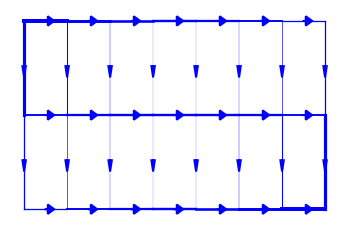

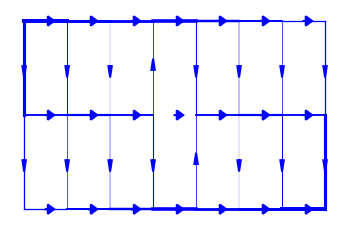

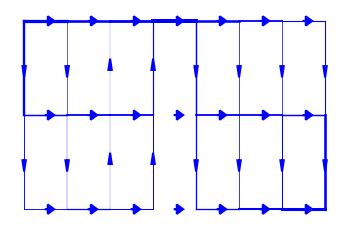

In [80]:
m, n, R = 3, 8, 1.
solver = UpdatableSolver(m, n, R)
visualize(m, n, R, solver.solve_voltage(220.))
plt.figure()
coeff = 1000
resistance_coeffs = {(1,3): coeff}
solver.update(1, 3, coeff)
visualize(m, n, R, solver.solve_voltage(220.), resistance_coeffs=resistance_coeffs)
plt.figure()
resistance_coeffs[(2,3)] = coeff
solver.update(2, 3, coeff)
visualize(m, n, R, solver.solve_voltage(220.), resistance_coeffs=resistance_coeffs)

Также проверим, что новый солвер работает для больших систем.

In [81]:
m, n, R = 300, 300, 1.
solver = UpdatableSolver(m, n, R)
solver.solve_voltage(220.)
solver.update(10, 20, 100.)
solver.update(20, 30, 100.)
solver.update(30, 40, 100.)
_ = solver.solve_voltage(220.)